# **Visual Question Answering**

## Installing CLIP

In [1]:
%pip install git+https://github.com/openai/CLIP.git --user

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-27gj5dt9
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-27gj5dt9
  Resolved https://github.com/openai/CLIP.git to commit a9b1bf5920416aaeaec965c25dd9e8f98c864f16
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 2.5 MB/s eta 0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369410 sha256=44f30618ee7c5e6148ada376097ca552b2a2d724598f9b43649aba32ce478355
  Stored in directory: /tmp/pip-ephem-wheel-cache-abamrre9/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
Note: you may need to restart the kernel to use updated packages.


## Importing Libraries

In [2]:
import os
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from wordcloud import WordCloud
from tabulate import tabulate
import seaborn as sns
from collections import Counter
from PIL import Image
from tabulate import tabulate
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import clip
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import average_precision_score
import json
import IPython.display as ipd

## Preprocessing Data

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: ", device)

Device:  cuda


In [4]:
def extract(path):
    df = pd.read_json(path)
    df = df[['image', 'question', 'answers', 'answer_type', 'answerable']]
    return df

In [5]:
def encode_images(df, image_path,  model, preprocessor, device):
    images = []
    c = 1
    print(c)
    for _, row in df.iterrows():
        c += 1
        if c % 10 == 0:
            ipd.clear_output(wait=False)
            print(c)
        image = Image.open(image_path + row['image'])
        image = preprocessor(image).unsqueeze(0).to(device)
        image_features =  model.encode_image(image)
        image_features = torch.flatten(image_features, start_dim=1)
        images.append(image_features)
    return images

def encode_questions(df, model,device):
    questions = []
    c = 1
    print(c)
    for _, row in df.iterrows():
        c += 1
        if c % 10 == 0:
            ipd.clear_output(wait=False)
            print(c)
        question = row['question']
        question =  clip.tokenize(question).to(device)
        text_features =  model.encode_text(question).float()
        text_features = torch.flatten(text_features, start_dim=1)
        questions.append(text_features)
    return questions

## Splitting Data

In [6]:
train_df = extract("/kaggle/input/vizwiz/Annotations/Annotations/train.json")
val_df = extract("/kaggle/input/vizwiz/Annotations/Annotations/val.json")
train_df, test_df = train_test_split(train_df, test_size = 0.05 , random_state = 42 , stratify = train_df[['answer_type', 'answerable']])

## Analysing Data

In [7]:
def plot_countplot(data_df, data_column):
    sns.countplot(x=list(data_df[data_column]))
    plt.title("Distribution of Answer Types")
    plt.xlabel("Answer Type")
    plt.ylabel("Count")
    plt.show()
    
def plot_piechart(data_df, data_column):
    counts = data_df[data_column].value_counts()
    plt.pie(counts, labels= counts.index, autopct = '%1.1f%%')
    plt.title(data_column)
    plt.show()    
    
def plot_wordcloud(data_df,  data_column):
    counts = np.unique(np.asarray(data_df[data_column]), return_counts=True)
    freq_dict = dict(zip(counts[0], counts[1]))
    wordcloud = WordCloud(width = 800, height = 500, background_color ='white', min_font_size = 10).generate_from_frequencies(freq_dict) 
    
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud, interpolation='bilinear') 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.show()  

def generate_question_table(data_df, data_column, num_top_questions=3):
    # Create a list to store the table data for each answer type
    table_data = []

    # Get the unique answer types
    unique_answer_types = data_df[data_column].unique()

    # Iterate over the unique answer types
    for answer_type in unique_answer_types:
        # Filter the data for the current answer type
        filtered_data = data_df[data_df[data_column] == answer_type]

        # Get the unique questions and their counts
        unique_questions, question_counts = filtered_data['question'].value_counts().index[:num_top_questions], filtered_data['question'].value_counts().values[:num_top_questions]

        # Create a table row for the current answer type
        table_row = [answer_type]

        # Add the top N most common questions and their counts to the table row
        for i in range(num_top_questions):
            table_row.append([unique_questions[i], question_counts[i]])

        # Append the table row to the table data
        table_data.append(table_row)

    # Define the table headers
    table_headers = ["Answer Type"] + [f"Question {i+1}" for i in range(num_top_questions)]

    # Format the table data with aligned columns
    formatted_table_data = []
    for row in table_data:
        formatted_row = []
        for item in row:
            if isinstance(item, str):
                formatted_row.append(item)
            elif isinstance(item, list):
                formatted_row.append(f"{item[0]}\nCount: {item[1]}")
        formatted_table_data.append(formatted_row)

    # Print the table
    print(tabulate(formatted_table_data, headers=table_headers, tablefmt="fancy_grid"))  
    
def display_random_images(image_paths, num_images=3, base_path=""):
    random_indices = np.random.choice(np.arange(len(image_paths)), size=num_images, replace=False)
    selected_paths = image_paths.iloc[random_indices]
    
    for image_path in selected_paths:
        # Construct the complete image path
        full_path = base_path + image_path

        # Read and display the image
        image = mpimg.imread(full_path)
        plt.imshow(image)
        plt.axis("off")
        plt.show() 

### Training Set

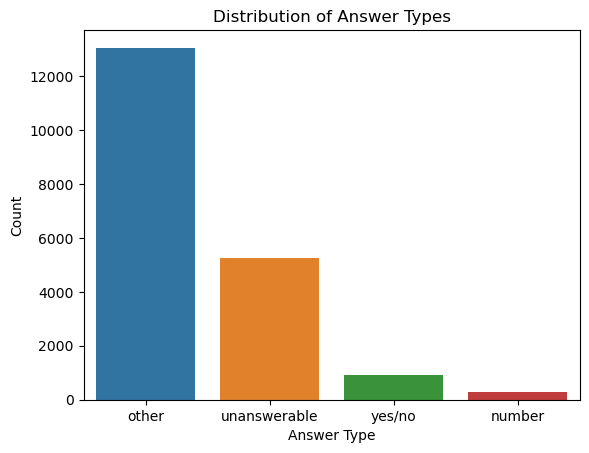

In [8]:
plot_countplot(train_df, 'answer_type')

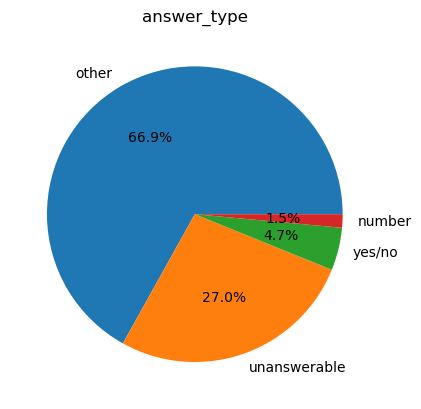

In [9]:
plot_piechart(train_df, 'answer_type')

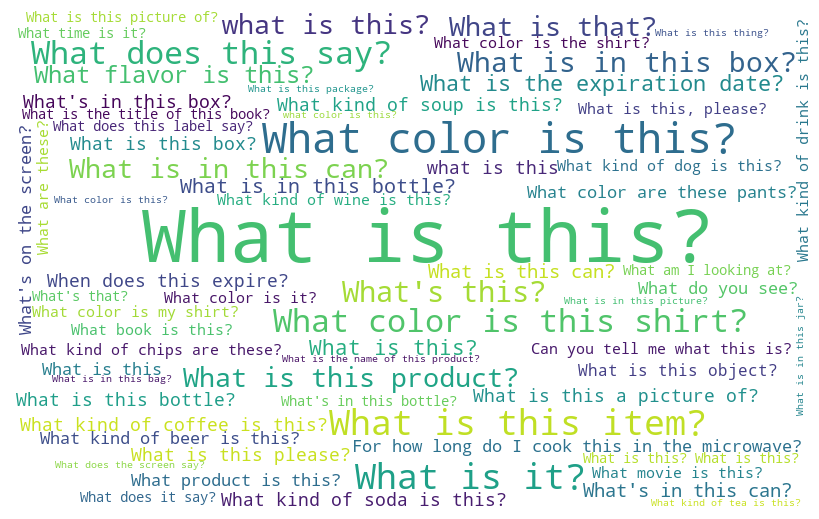

In [10]:
plot_wordcloud(train_df,'question')

In [11]:
generate_question_table(train_df,'answer_type', num_top_questions=3)

╒═══════════════╤═══════════════════╤═════════════════════════════════════════╤═══════════════════════╕
│ Answer Type   │ Question 1        │ Question 2                              │ Question 3            │
╞═══════════════╪═══════════════════╪═════════════════════════════════════════╪═══════════════════════╡
│ other         │ What is this?     │ What color is this?                     │ What is it?           │
│               │ Count: 2298       │ Count: 351                              │ Count: 214            │
├───────────────┼───────────────────┼─────────────────────────────────────────┼───────────────────────┤
│ unanswerable  │ What is this?     │ What is the expiration date?            │ What does this say?   │
│               │ Count: 289        │ Count: 70                               │ Count: 60             │
├───────────────┼───────────────────┼─────────────────────────────────────────┼───────────────────────┤
│ yes/no        │ Is my light on?   │ Is this shampoo?          

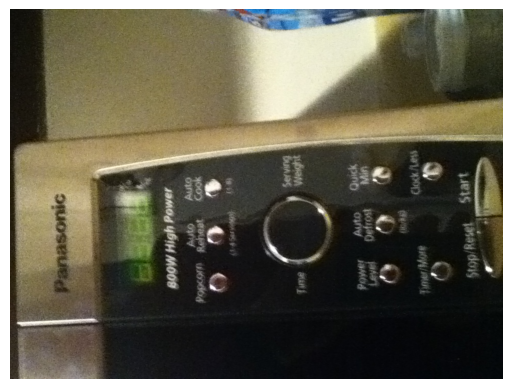

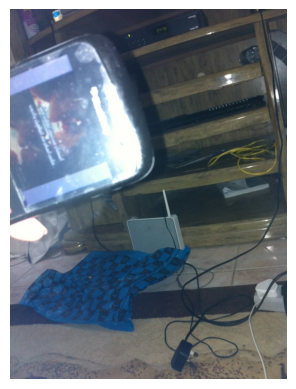

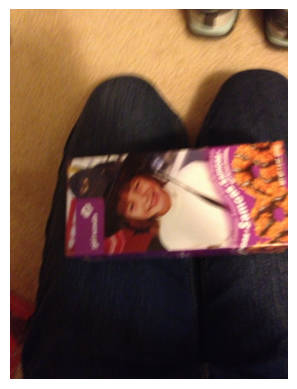

In [12]:
display_random_images(train_df['image'], num_images=3, base_path="/kaggle/input/vizwiz/train/train/")

### Validation Set

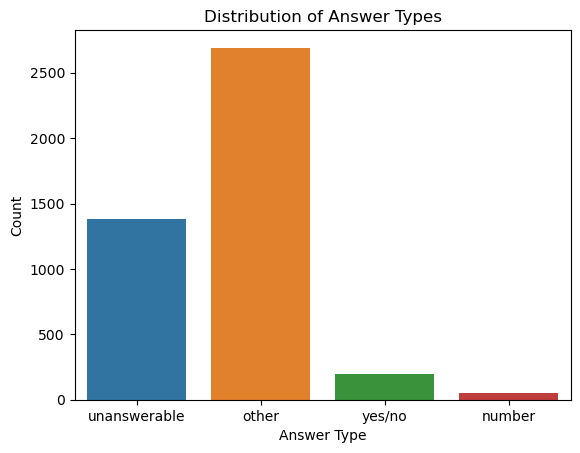

In [13]:
plot_countplot(val_df, 'answer_type')

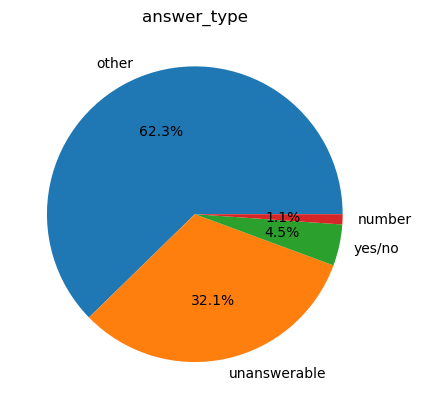

In [14]:
plot_piechart(val_df, 'answer_type')

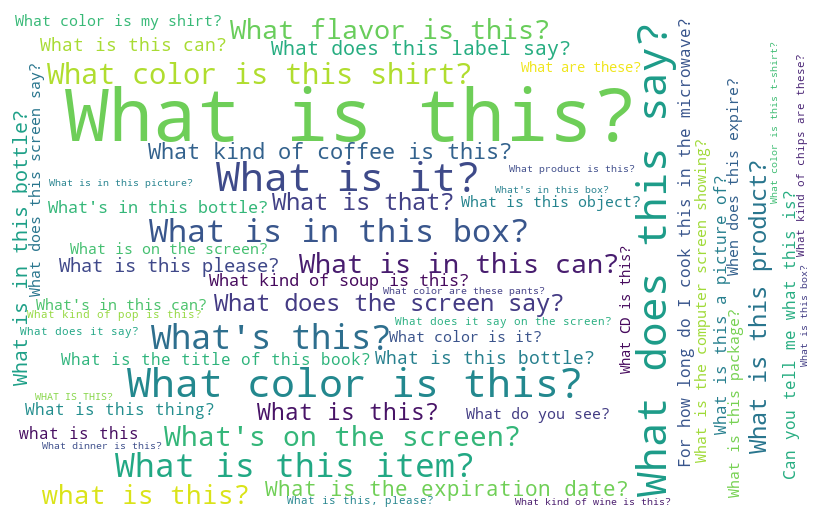

In [15]:
plot_wordcloud(val_df,'question')

In [16]:
generate_question_table(val_df,'answer_type', num_top_questions=3)

╒═══════════════╤═════════════════════════════════════════╤══════════════════════════╤══════════════════════════════════════════╕
│ Answer Type   │ Question 1                              │ Question 2               │ Question 3                               │
╞═══════════════╪═════════════════════════════════════════╪══════════════════════════╪══════════════════════════════════════════╡
│ unanswerable  │ What is this?                           │ What does this say?      │ What is it?                              │
│               │ Count: 88                               │ Count: 35                │ Count: 11                                │
├───────────────┼─────────────────────────────────────────┼──────────────────────────┼──────────────────────────────────────────┤
│ other         │ What is this?                           │ What color is this?      │ What is it?                              │
│               │ Count: 435                              │ Count: 56                │ Cou

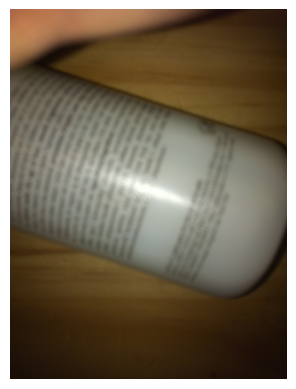

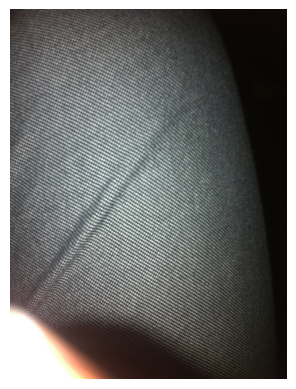

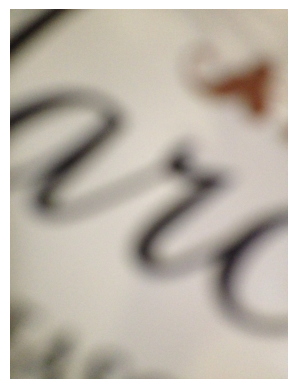

In [17]:
display_random_images(val_df['image'], num_images=3, base_path="/kaggle/input/vizwiz/val/val/")

### Test Set

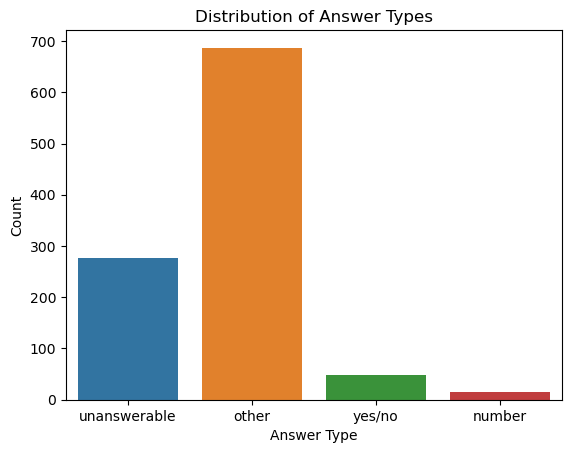

In [18]:
plot_countplot(test_df, 'answer_type')

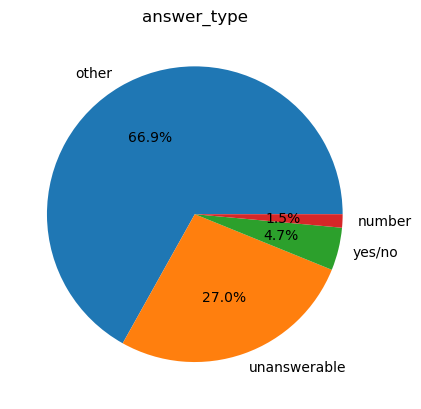

In [19]:
plot_piechart(test_df, 'answer_type')

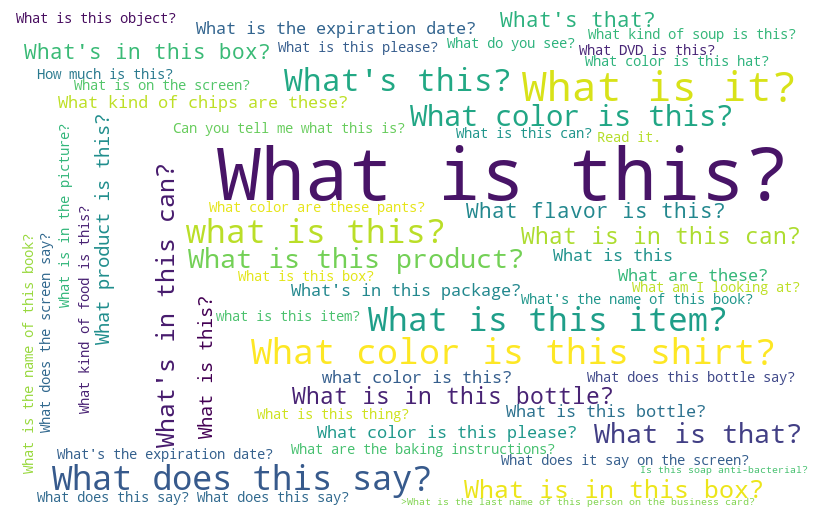

In [20]:
plot_wordcloud(test_df,'question')

In [21]:
generate_question_table(test_df,'answer_type', num_top_questions=3)

╒═══════════════╤═══════════════════════════════════════════════════════════════════════════════════════╤═════════════════════════════════════════════════╤═════════════════════════════╕
│ Answer Type   │ Question 1                                                                            │ Question 2                                      │ Question 3                  │
╞═══════════════╪═══════════════════════════════════════════════════════════════════════════════════════╪═════════════════════════════════════════════════╪═════════════════════════════╡
│ unanswerable  │ What is this?                                                                         │ What does this say?                             │ What product is this?       │
│               │ Count: 16                                                                             │ Count: 4                                        │ Count: 3                    │
├───────────────┼─────────────────────────────────────────────────────

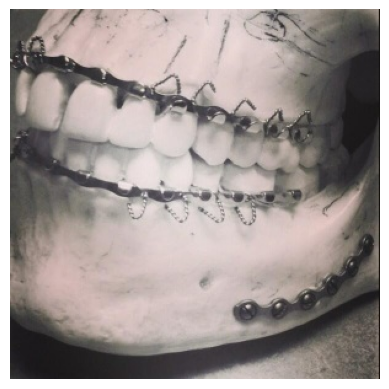

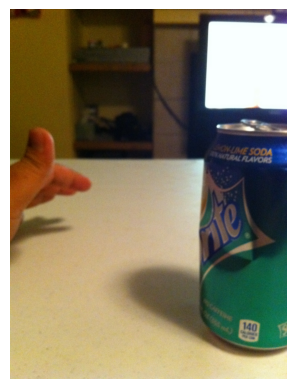

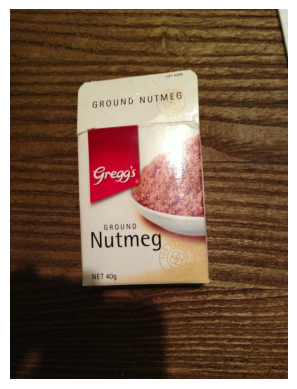

In [22]:
display_random_images(test_df['image'], num_images=3, base_path="/kaggle/input/vizwiz/train/train/")

## Encoding Images & Questions using CLIP

In [23]:
clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [24]:
ViTL_model,  preprocess_ViTL = clip.load("ViT-L/14@336px", device =  device)
ViTL_model.eval().requires_grad_(False)

input_resolution_ViTL = ViTL_model.visual.input_resolution
context_length_ViTL = ViTL_model.context_length
vocab_size_ViTL = ViTL_model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in ViTL_model.parameters()]):,}")
print("Input resolution:", input_resolution_ViTL)
print("Context length:", context_length_ViTL)
print("Vocab size:", vocab_size_ViTL)

100%|███████████████████████████████████████| 891M/891M [00:14<00:00, 62.9MiB/s]


Model parameters: 427,944,193
Input resolution: 336
Context length: 77
Vocab size: 49408


In [ ]:
images_train =  encode_images(train_df,'/kaggle/input/vizwiz/train/train/', ViTL_model,  preprocess_ViTL,  device)
questions_train =  encode_questions(train_df, ViTL_model,  device)

images_val =  encode_images(val_df, '/kaggle/input/vizwiz/val/val/', ViTL_model,  preprocess_ViTL,  device)
questions_val =  encode_questions(val_df, ViTL_model,  device)

images_test =  encode_images(test_df, '/kaggle/input/vizwiz/train/train/', ViTL_model,  preprocess_ViTL,  device)
questions_test =  encode_questions(test_df, ViTL_model,  device)

90


## Creating PyTorch Dataset Class

In [ ]:
class MyDataset(Dataset):
    def __init__(self,  df, encoder_answer_type = None, encoder_answer = None, image_features_ViTL = torch.tensor([]), question_features_ViTL = torch.tensor([])):
        super(MyDataset, self).__init__()
        self.answer_counter = Counter() 
        self.image_features_ViTL = image_features_ViTL
        self.question_features_ViTL = question_features_ViTL
        self.df =  df
        self.sample_answer_count = []
        self.answerable =  df['answerable'].to_numpy()

        for row in self.df['answers']:
            for  sample_answers in row:
                self.answer_counter.update([sample_answers['answer']])

        self. get_unique_answers()
        
        if encoder_answer_type is None:
            encoder_answer_type = OneHotEncoder(handle_unknown='ignore')
            encoder_answer_type.fit(self.dataframe[['answer_type']])
        self.encoder_answer_type = encoder_answer_type
             
        if encoder_answer is None:
            encoder_answer = OneHotEncoder(handle_unknown='ignore')
            encoder_answer.fit(self.dataframe[['answer']])
        self.encoder_answer = encoder_answer
  
        self.encoded_answer = encoder_answer.transform(self.dataframe[['answer']]).toarray()
        self.encoded_answer_type = encoder_answer_type.transform(self.dataframe[['answer_type']]).toarray()
        self.unique_answers_train = self.encoder_answer.categories_[0].tolist()
        
        for idx, row in self.df.iterrows():
            hold = []
            for  sample_answers in row['answers']:
                answer =  sample_answers['answer']
                if answer in self.unique_answers_train:
                    answer_idx = self.unique_answers_train.index(answer)
                    hold.append(answer_idx)
            while len(hold) < 10:
                hold.append(-1)
            self.sample_answer_count.append(hold)      
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self,  idx):
        answer = torch.tensor(self.encoded_answer[ idx], dtype=torch.float32)
        answer_type = torch.tensor(self.encoded_answer_type[ idx], dtype=torch.float32)
        answer_count = torch.tensor(self.sample_answer_count[ idx], dtype=torch.long)
        answerable = torch.tensor(self.answerable[ idx], dtype=torch.float32)
        return self.image_features_ViTL[ idx], self.question_features_ViTL[ idx], answer, answer_type, answer_count, answerable

    def  get_unique_answers(self):
        self.dataframe = self.df.copy()
        self.dataframe.drop(columns=['answers'], inplace=True)
        self.dataframe['answer'] = None
        for  idx, row in self.df.iterrows():
            answer_counter = Counter()
            for answers in row['answers']:
                answer = answers['answer']
                answer_counter.update([answer])
                top = answer_counter.most_common(1)
            self.dataframe.at[ idx, 'answer'] = top[0][0]
        return
    
    def unique_answers(self):
        return self.dataframe['answer'].unique()

## Building Model

In [ ]:
class LinearNet(nn.Module):
    
    def __init__(self, num_classes,  model = "ViT-L/14@336px", device = torch.device("cpu")):
        super(LinearNet, self).__init__()

        self.loss_train = []
        self.loss_val = []

        self.acc_vizwiz_train = []
        self.acc_vizwiz_val = []

        self.ans_train = []
        self.ans_val = []
        
        self.device = device
        self.model =  model
        
        self.ans_loss_fn = nn.BCELoss()   

        self.clip_model, self.preprocess = clip.load( model, device = device)
        
        for param in self.clip_model.parameters():
            param.requires_grad = False

        self.fc1 = nn.Sequential(
            nn.LayerNorm(self.clip_model.visual.output_dim + self.clip_model.text_projection.shape[1]),
            nn.Dropout(p=0.5),
            nn.Linear(self.clip_model.visual.output_dim + self.clip_model.text_projection.shape[1], 512)
        )

        self.fc2 = nn.Sequential(
            nn.LayerNorm(512),
            nn.Dropout(p=0.5),
            nn.Linear(512, num_classes) 
        )

        self.fc_aux = nn.Linear(512, 4)
        self.fc_gate = nn.Linear(4, num_classes)
        self.act_gate = nn.Sigmoid()

        self.fc_ans = nn.Sequential(
            nn.LayerNorm(self.clip_model.visual.output_dim + self.clip_model.text_projection.shape[1]),
            nn.Linear(self.clip_model.visual.output_dim + self.clip_model.text_projection.shape[1], 512)
        )
        
        self.fc_ans2 = nn.Linear(512, 1)
        self.ans_gate = nn.Sigmoid()

    def forward(self, image, question):

        image = torch.flatten(image, start_dim=1)
        question = torch.flatten(question, start_dim=1)
        x = torch.cat((image, question), dim=1)
        
        ans = self.fc_ans(x)
        ans = self.fc_ans2(ans)
        ans = self.ans_gate(ans)
        ans = ans.squeeze()
        
        x = self.fc1(x)
        
        aux = self.fc_aux(x)
        gate = self.fc_gate(aux)
        gate = self.act_gate(gate)
        
        vqa = self.fc2(x)
        output = vqa * gate
        
        return output, aux, ans
    
    def train_model(self, train_dataloader, val_dataloader, criterion, optimizer, num_epochs):
        
        for epoch in range(0,num_epochs):
            
            train_loss, train_vizwiz_acc, train_ans = self.train_step(train_dataloader, criterion, optimizer, self.device)
            val_loss, val_vizwiz_acc, val_ans = self.val_step(val_dataloader, criterion, self.device)

            self.loss_train.append(train_loss)
            self.loss_val.append(val_loss)

            self.acc_vizwiz_train.append(train_vizwiz_acc)
            self.acc_vizwiz_val.append( val_vizwiz_acc)

            self.ans_train.append(train_ans)
            self.ans_val.append(val_ans)

            print(f"Epoch {epoch+1}/{num_epochs}:")
            print(f"Training Loss: {train_loss:.4f} | Validation Loss: {val_loss:.4f}")
            print(f"Training Vizwiz Accuracy: {train_vizwiz_acc:.4f} | Validation Vizwiz Accuracy: { val_vizwiz_acc:.4f}")
            print(f"Training Answerability Score: {train_ans:.4f} | Validation Answerability Score: {val_ans:.4f}")
            print()
              
        return
    
    def train_step(self, dataloader, criterion, optimizer, device):
        
        training_loss, vizwiz_acc, sum = 0.0, 0.0, 0
        true_answerable = []
        predicted_answerable = []
        
        self.train()
        for _, batch in enumerate(dataloader):
            
            image,question,answer,answer_type,question_answers,answerable = batch
            image,question,answer,answer_type,question_answers,answerable = image.to(device), question.to(device), answer.to(device), answer_type.to(device), question_answers.to(device), answerable.to(device)
            optimizer.zero_grad()
            output, aux, ans = self.forward(image, question)
            
            answerable = 1 - answerable
            ans = 1.0 - ans
            
            loss = criterion(output, answer) + criterion(aux, answer_type) + self.ans_loss_fn(ans, answerable)
            loss.backward()
            optimizer.step()
            
            training_loss += loss.item()
            predicted_answer = torch.argmax(output, dim = 1)
            true_answer = torch.argmax(answer, dim = 1)
            
            for i in range(len(answer)):
                
                sum +=1
                vizwiz_acc += min(1, torch.sum(torch.eq(predicted_answer[i], question_answers[i])).item()/3)
                true_answerable.append(answerable[i].item())
                predicted_answerable.append(ans[i].item())
        

        true_answerable = np.array(true_answerable)
        predicted_answerable = np.array(predicted_answerable)

        training_loss /= len(dataloader)
        vizwiz_acc /= sum
        
        return training_loss, vizwiz_acc, average_precision_score(true_answerable, predicted_answerable, average = 'weighted')
            
    
    def val_step(self, dataloader, criterion, device):
        
        val_loss, vizwiz_acc, sum = 0.0, 0.0, 0
        answerable_true = []
        answerable_predicted = []
        
        self.eval()
        with torch.no_grad():
            for _, batch in enumerate(dataloader):
                
                image,question,answer,answer_type,question_answers,answerable = batch
                image,question,answer,answer_type,question_answers,answerable = image.to(device), question.to(device), answer.to(device), answer_type.to(device),  question_answers.to(device), answerable.to(device)
                output, aux, ans = self.forward(image, question)
                
                answerable = 1 - answerable
                ans = 1.0 - ans
                loss = criterion(output, answer) + criterion(aux, answer_type) + self.ans_loss_fn(ans, answerable)
                val_loss += loss.item()
                
                predicted_answer = torch.argmax(output, dim = 1)
                actual_answer = torch.argmax(answer, dim = 1)
                
                for i in range(len(answer)):
                    
                    if torch.sum(answer[i]) == 0:
                        continue
                    sum +=1
                    
                    vizwiz_acc += min(1, torch.sum(torch.eq(predicted_answer[i],  question_answers[i])).item()/3)
                    answerable_true.append(answerable[i].item())
                    answerable_predicted.append(ans[i].item())
                    
        answerable_true = np.array(answerable_true)
        answerable_predicted = np.array(answerable_predicted)
        
        val_loss /= len(dataloader)
        vizwiz_acc /= sum
        
        return  val_loss, vizwiz_acc, average_precision_score(answerable_true, answerable_predicted, average = 'weighted')
    
    def test_step(self, dataloader):
        
        acc, sum,  vizwiz_acc = 0.0, 0, 0.0
        answerable_true = []
        answerable_predicted = []
        
        self.eval()
        with torch.no_grad():
            for _, batch in enumerate(dataloader):
                
                image,question,answer,answer_type,question_answers,answerable = batch
                image,question,answer,answer_type,question_answers,answerable = image.to(self.device), question.to(self.device), answer.to(self.device), answer_type.to(self.device), question_answers.to(self.device), answerable.to(self.device)
                output, _, ans = self.forward(image, question)
                
                answerable = 1 - answerable
                ans = 1.0 - ans
                
                predicted_answer = torch.argmax(output, dim = 1)
                true_answer = torch.argmax(answer, dim = 1)
                
                for i in range(len(answer)):
                    
                    if torch.sum(answer[i]) == 0:
                        continue
                    if predicted_answer[i] == true_answer[i]:
                         acc += 1
                            
                    vizwiz_acc += min(1, torch.sum(torch.eq(predicted_answer[i], question_answers[i])).item()/3)
                    sum +=1
                    
                    answerable_true.append(answerable[i].item())
                    answerable_predicted.append(ans[i].item())
            
        answerable_true = np.array(answerable_true)
        answerable_predicted = np.array(answerable_predicted)
        
        acc /= sum
        vizwiz_acc /= sum
        return  acc, vizwiz_acc, average_precision_score(answerable_true, answerable_predicted, average = 'weighted')


    def predict(self, image, question):
       
        output, aux, ans = self.forward(image, question)
        ans = 1.0 - ans
        return output, aux, ans


    def test_model(self, image_path, question):
     
        self.eval()
        image = Image.open(image_path)

        image = self.preprocess(image).unsqueeze(0).to(self.device)
        image_features = self.clip_model.encode_image(image)
        image_features = torch.flatten(image_features, start_dim=1)

        question =  clip.tokenize(question).to(self.device)
        text_features = self.clip_model.encode_text(question).float()
        text_features = torch.flatten(text_features, start_dim=1)

        predicted_answer, predicted_answer_type, predicted_answerability = self.predict(image_features, text_features)
        return predicted_answer, predicted_answer_type, predicted_answerability


## Training Model

In [28]:
train_dataset =  MyDataset(train_df, None, None, images_train, questions_train)
model_encoder_answer = train_dataset.encoder_answer
model_encoder_answer_type = train_dataset.encoder_answer_type
val_dataset = MyDataset(val_df, model_encoder_answer_type, model_encoder_answer, images_val, questions_val)
test_dataset = MyDataset(test_df, model_encoder_answer_type, model_encoder_answer, images_test, questions_test)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32)
test_dataloader = DataLoader(test_dataset, batch_size=32)

In [29]:
model = LinearNet(num_classes=len(train_dataset.unique_answers()), device = device,  model="ViT-L/14@336px").to(device)

loss_function = nn.CrossEntropyLoss().to( device)
optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay = 0)

model.train_model(train_dataloader, val_dataloader, loss_function, optimizer, num_epochs=20)

Epoch 1/20:
Training Loss: 6.9546 | Validation Loss: 4.0396
Training Vizwiz Accuracy: 0.3718 | Validation Vizwiz Accuracy: 0.4489
Training Answerability Score: 0.7035 | Validation Answerability Score: 0.8215

Epoch 2/20:
Training Loss: 6.1668 | Validation Loss: 3.7848
Training Vizwiz Accuracy: 0.3997 | Validation Vizwiz Accuracy: 0.4717
Training Answerability Score: 0.7488 | Validation Answerability Score: 0.7954

Epoch 3/20:
Training Loss: 5.5854 | Validation Loss: 3.4683
Training Vizwiz Accuracy: 0.4322 | Validation Vizwiz Accuracy: 0.5022
Training Answerability Score: 0.7625 | Validation Answerability Score: 0.8193

Epoch 4/20:
Training Loss: 5.0658 | Validation Loss: 3.3107
Training Vizwiz Accuracy: 0.4609 | Validation Vizwiz Accuracy: 0.5506
Training Answerability Score: 0.7654 | Validation Answerability Score: 0.8098

Epoch 5/20:
Training Loss: 4.5642 | Validation Loss: 3.1268
Training Vizwiz Accuracy: 0.4876 | Validation Vizwiz Accuracy: 0.5451
Training Answerability Score: 0.77

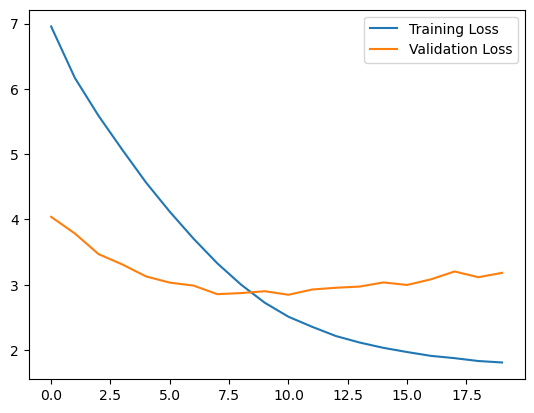

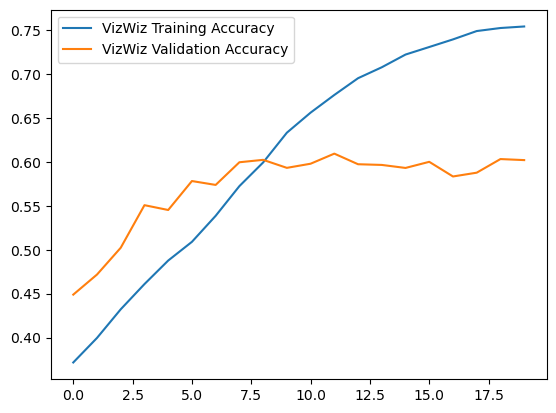

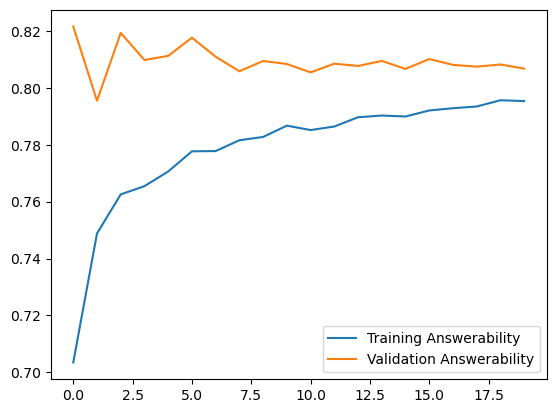

In [30]:
#plotting training losses and validation losses
plt.plot(model.loss_train, label = "Training Loss")
plt.plot(model.loss_val, label = "Validation Loss")
plt.legend()
plt.show()

#plotting vizwiz training and validation accuracy
plt.plot(model.acc_vizwiz_train, label = "VizWiz Training Accuracy")
plt.plot(model.acc_vizwiz_val, label = "VizWiz Validation Accuracy")
plt.legend()
plt.show()

#plotting training and validation answerability
plt.plot(model.ans_train, label = "Training Answerability")
plt.plot(model.ans_val, label = "Validation Answerability")
plt.legend()
plt.show()

## Testing Model

In [31]:
test_accuracy, test_vizwiz_accuracy, test_answerability_score = model.test_step(test_dataloader)

## Evaluating Model

In [32]:
print("Test Accuracy : {:.3f} \nTest Vizwiz Accuracy : {:.3f} \nTest Answerability Score : {:.3f}\n".format(test_accuracy, test_vizwiz_accuracy, test_answerability_score))

Test Accuracy : 0.517 
Test Vizwiz Accuracy : 0.677 
Test Answerability Score : 0.804



## Testing unseen images

Enter image path: /kaggle/input/vizwiz/test/test/VizWiz_test_00000106.jpg
Ask a question: What is this?


Answer: glass
Answer Type: other


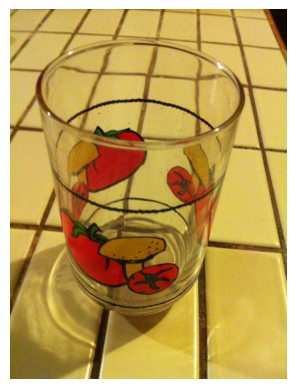

In [34]:
#Enter image path from kaggle input folder
image_path_user = input("Enter image path:")
question_user = input("Ask a question:")

predicted_answer, predicted_answer_type, answerability = model.test_model(image_path = image_path_user, question = question_user)
answer = model_encoder_answer.inverse_transform(predicted_answer.cpu().detach().numpy())
answer_type = model_encoder_answer_type.inverse_transform(predicted_answer_type.cpu().detach().numpy())

print("Answer: " + answer[0][0])
print("Answer Type: " + answer_type[0][0])
image = mpimg.imread(image_path_user)
plt.imshow(image)
plt.axis("off")
plt.show() 